# Carvana via UNET

In [1]:
import torch 
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from model import UNET
from utils import get_loaders, save_checkpoint, load_checkpoint, validation, save_predictions_as_imgs

## Preset

In [2]:
LR = 1e-4
BS = 16
EPOCHS = 5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False

IMAGE_DIR = '/home/shikamaru/datasets/carvana-image-masking-challenge/train'
MASK_DIR = '/home/shikamaru/datasets/carvana-image-masking-challenge/train_masks'
IMAGE_HEIGHT = 160
IMAGE_WIDTH = 240

In [3]:
def train(dataloader, model, optimizer, loss_fn, scaler):
    loop = tqdm(dataloader)

    for batch_idx, (data, masks) in enumerate(loop):
        data = data.to(device=DEVICE)
        masks = masks.float().unsqueeze(1).to(device=DEVICE)  # float() for BCE loss, unsqueeze() adds the channel dimension. 

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, masks)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm
        loop.set_postfix(loss=loss.item())

In [4]:
transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            # A.Rotate(limit=35, p=1.0),
            # A.HorizontalFlip(p=0.3), 
            # A.VerticalFlip(p=0.1), 
            A.Normalize(
                mean=[0.0, 0.0, 0.0], 
                std=[1.0, 1.0, 1.0], 
                max_pixel_value=255.0
            ), 
            ToTensorV2()
        ]
    )

In [5]:
model = UNET(in_channels=3, out_channels=1, features=[4,8,16,32]).to(device=DEVICE)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_loader, val_loader = get_loaders(
    train_dir=IMAGE_DIR, 
    mask_dir=MASK_DIR, 
    batch_size=BS, 
    transform=transform, 
    num_workers=NUM_WORKERS, 
    pin_memory=PIN_MEMORY, 
    val_size=0.2
   )
    
scaler = torch.cuda.amp.GradScaler()

## Train & Validation

In [13]:
for epoch in range(EPOCHS):
    train(train_loader, model, optimizer, loss, scaler)

    # save checkpoint
    checkpoint = {
        'state_dict': model.state_dict(), 
        'optimizer': optimizer.state_dict()
    }
    save_checkpoint(checkpoint)

100%|██████████| 255/255 [01:28<00:00,  2.88it/s, loss=0.446]


=> Saving checkpoint...
=> Checkpoint saved. 


100%|██████████| 255/255 [01:31<00:00,  2.80it/s, loss=0.384]


=> Saving checkpoint...
=> Checkpoint saved. 


100%|██████████| 255/255 [01:32<00:00,  2.76it/s, loss=0.36] 


=> Saving checkpoint...
=> Checkpoint saved. 


100%|██████████| 255/255 [01:31<00:00,  2.79it/s, loss=0.313]


=> Saving checkpoint...
=> Checkpoint saved. 


100%|██████████| 255/255 [01:31<00:00,  2.80it/s, loss=0.288]


=> Saving checkpoint...
=> Checkpoint saved. 


In [14]:
# validation
validation(model, val_loader)

100%|██████████| 64/64 [00:22<00:00,  2.84it/s]

Average DICE: 9.769099906086922
Average IoU: 0.4435906484723091


## Prediction

In [6]:
model = UNET(in_channels=3, out_channels=1, features=[4,8,16,32]).to(device=DEVICE)
load_checkpoint(checkpoint=torch.load('checkpoint.pth.tar'), model=model)

=> Loading checkpoint...
=> Checkpoint loaded. 


In [8]:
save_predictions_as_imgs(val_loader, model, folder="save_images")

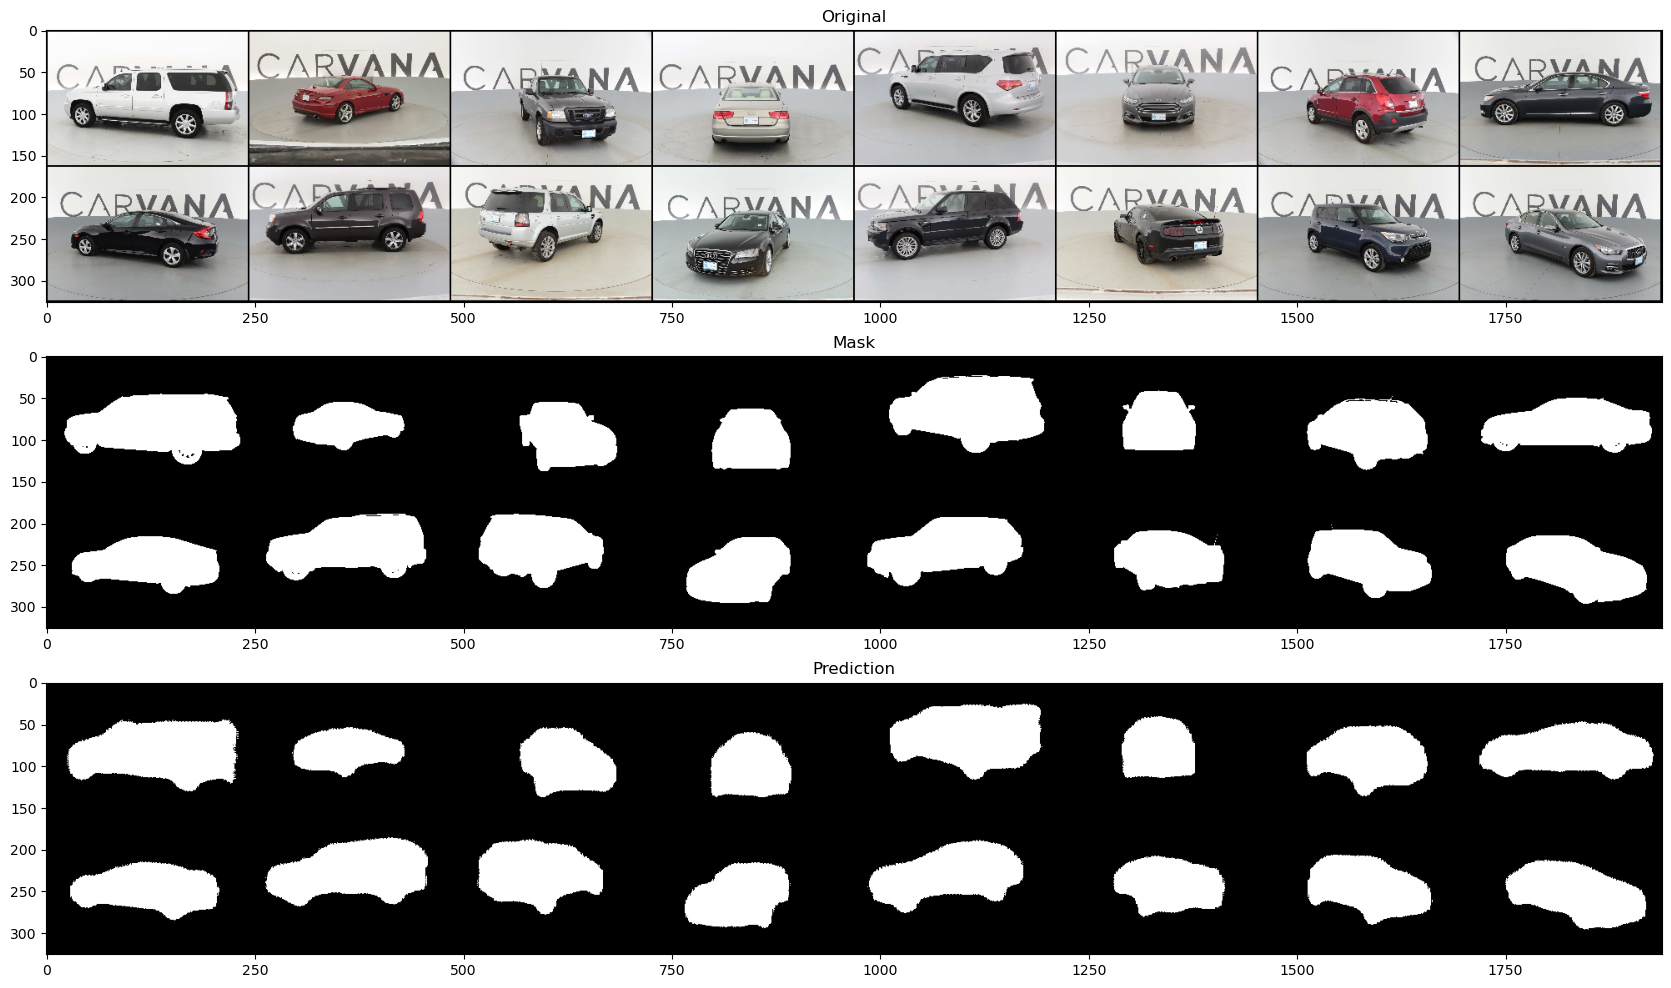

In [9]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image_folder = 'save_images'
filenames = ['orig_0.png', 'masks_0.png', 'pred_0.png']
n = len(filenames) # 图像的数量
images = [] # 创建一个空列表，用于存储图像
for i in range(n): # 遍历每个文件名
    img = mpimg.imread(os.path.join(image_folder, filenames[i])) # 读取第 i 个文件对应的图像
    images.append(img) # 将图像添加到列表中
# 接下来，您可以使用我之前提到的 add_subplot() 函数和 imshow() 函数显示每个图像

n = len(images) # 图像的数量
titles = ['Original', 'Mask', 'Prediction']
fig = plt.figure(figsize=(32, n*4)) # 创建一个图形对象，设置大小
for i in range(n): # 遍历每个图像
    ax = fig.add_subplot(n, 1, i+1) # 在第 i+1 个位置创建一个子图
    ax.imshow(images[i]) # 显示第 i 个图像
    ax.set_title(titles[i])
plt.show() # 显示整个图形